# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 05-03-2025<br>

**Introduction:**<br>
This code downloads the reservoir time series available in the HYDRO data base for a specific country.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml

from lisfloodreservoirs.utils import DatasetConfig, APIConfig

In [2]:
import unicodedata

def remove_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn'
    )

## Configuration

In [3]:
COUNTRY_ID = None # 'HR'

# # dataset cofiguration
# cfg = DatasetConfig(f'./ResOps{COUNTRY_ID}/config_dataset.yml')

# HDMS API configuration
api = APIConfig('./HDMS_API.yml')

# study period
strftime = '%Y-%m-%dT%H:%M:%S'

# variables of interest
VARIABLES = {
    'O': 'outflow',
    'V': 'volume',
    'R': 'level'
}

# directory of the HDMS dataset
PATH_HDMS = Path('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs')

## Reservoirs

In [4]:
service = 'stationsmdv2'

url = f'{api.URL}/{service}/json/' #provider/{PROVIDER_ID}/'
response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
if response.status_code == 200:
    # convert to pandas
    reservoirs = pd.DataFrame(response.json())
    reservoirs.columns = reservoirs.columns.str.upper()
    reservoirs.set_index('EFAS_ID', drop=True, inplace=True)

    # keep only reservoirs in the specific country
    mask_type = reservoirs.TYPE == 'RESERVOIR'
    if COUNTRY_ID:
        mask_country = reservoirs['COUNTRY-CODE'] == COUNTRY_ID
    else:
        mask_country = True
    reservoirs = reservoirs[mask_type & mask_country]

    # organize fields
    reservoirs.dropna(axis=1, how='all', inplace=True)
    reservoirs.drop(['LATITUDE_GEODESIC', 'LONGITUDE_GEODESIC', 'GEODESIC_REFERENCE_SYSTEM', 'VARIABLES', 'CATCHMENT_AREA_UNITS', 'HEIGHT_UNITS', 'TYPE'],
                    axis=1,
                    inplace=True,
                    errors='ignore')
    reservoirs.rename(columns={
         'HAS_RTDATA': 'DATA_RT',
         'HAS_HISTORICAL_DATA': 'DATA_HIST',
         'NAME': 'RES_NAME',
         'NATIONAL_STATION_IDENTIFIER': 'LOCAL_ID',
         'PROVIDER_ID': 'PROV_ID',
         'COUNTRY-CODE': 'COUNTRY_ID',
         'BASIN_ENGLISH': 'BASIN_EN',
         'BASIN_LOCAL': 'BASIN_LOC',
         'RIVERNAME_LOCAL': 'RIVER_LOC',
         'RIVERNAME_ENGLISH': 'RIVER_EN',
         'CATCHMENT_AREA': 'CATCH_SKM',
         'LATITUDE_WGS84': 'LAT',
         'LONGITUDE_WGS84': 'LON',
         'COORDINATES_CHECKED': 'COORD_TEST',
         'HEIGHT': 'DAM_HGT_M',
         'HEIGHT_REFERENCE_SYSTEM': 'HEIGHT_RS',
         'LOCAL_REFERENCE_SYSTEM': 'LOCAL_RF',
         'DATE_OF_STARTING_MEASUREMENT': 'START',
         'DATE_OF_ENDING_MEASUREMENT': 'END',
         'DATE_OF_REGISTRATION': 'REGISTERED',
         'LAST_CHANGE_COMMENT': 'COMMENT_',
         'X-COORDINATE': 'X',
         'Y-COORDINATE': 'Y',
    }, inplace=True)
    reservoirs.sort_index(axis=1, inplace=True)

    # convert to geopandas
    geometry = [Point(xy) for xy in zip(reservoirs.LON, reservoirs.LAT)]
    reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry)
    reservoirs.set_crs(epsg=4326, inplace=True)

In [5]:
# fix country names
reservoirs.COUNTRY_ID = reservoirs.COUNTRY_ID.str.upper()
reservoirs.COUNTRY = reservoirs.COUNTRY.str.capitalize()
map_countries = {ID: reservoirs[reservoirs.COUNTRY_ID == ID].COUNTRY.value_counts().index[0] for ID in reservoirs.COUNTRY_ID.unique()}
reservoirs.COUNTRY = reservoirs.COUNTRY_ID.map(map_countries)

reservoirs.COUNTRY_ID.value_counts()

ES    512
PT     20
HR     10
DE      3
MD      2
Name: COUNTRY_ID, dtype: int64

In [6]:
# treat string columns
col_names = ['RES_NAME', 'BASIN_LOC', 'BASIN_EN', 'RIVER_LOC', 'RIVER_EN']
reservoirs[col_names] = reservoirs[col_names].astype(str).replace('nan', '')
for col in col_names:
    reservoirs[col] = reservoirs[col].str.lower().apply(remove_accents)

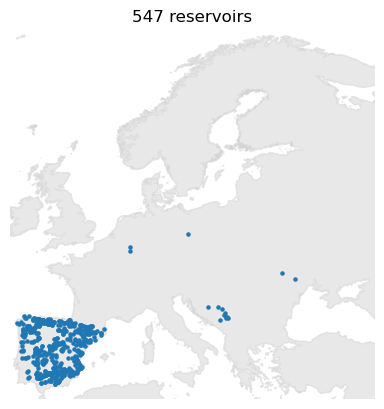

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
reservoirs.plot(markersize=5, ax=ax)
ax.set_title(f'{len(reservoirs)} reservoirs')
ax.set_extent([-10, 40, 35.5, 70])
ax.axis('off');

In [8]:
# export
# PATH_GIS = cfg.PATH_RESOPS / 'GIS'
PATH_GIS = PATH_HDMS / 'GIS'
PATH_GIS.mkdir(parents=True, exist_ok=True)
reservoirs.to_file(PATH_GIS / 'reservoirs_HDMS_{0}.shp'.format(datetime.now().strftime('%Y%m%d')))

**Duplicated by distance**

In [9]:
def find_duplicates(
    gdf: gpd.GeoDataFrame,
    provider_col: str = 'PROV_ID',
    distance_thr: float = 1500
):
    """Finds duplicates in the input GeoDataFrame based on distance (points closer than the threshold) and provider (if they have different provider)
    
    Parameters:
    -----------
    gdf: geopandas.GeoDataFrame
        table of reservoirs/stations in the database
    provider_col: str
        column in "gdf" that defines the provider. Duplicates must have a different provider
    distance_thr: float
        distance below which duplicates can exist. Points further apart than this distance will not be spotted as duplicates. The values depend on the reference coordinate system in "gdf"
        
    Returns:
    --------
    A list of lists with groups of duplicates. The values are the index in "gdf"
    """
    
    duplicates = []
    for ID, point in gdf.geometry.items():
        if any(ID in sublist for sublist in duplicates):
            continue
        
        prov_id = gdf.loc[ID, provider_col]

        # distance to the other reservoirs
        others = gdf[gdf.index != ID]
        distance = others.geometry.distance(point)

        # find close reservoirs
        if distance.min() < distance_thr:
            ids = distance[distance < distance_thr].index.tolist()
            ids = [id for id in ids if gdf.loc[id, provider_col] != prov_id]
            if len(ids) > 0:
                duplicates.append([ID] + ids)
                
    return duplicates

In [272]:
# find duplicates based on distance and provider
duplicates = find_duplicates(reservoirs, provider_col='PROV_ID', distance_thr=.01667)
print(len(duplicates))

# export
with open("duplicated_reservoirs.txt", "w") as file:
    for sublist in duplicates:
        file.write(','.join(map(str, sublist)) + '\n')

C:\Users\casadje\AppData\Local\Temp\ipykernel_612\3232567946.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distance = others.geometry.distance(point)


99


**Duplicated reservoir names**

In [170]:
# mapping local and English river names
# river_loc_en = {}
# for river_loc in reservoirs.RIVER_LOC.unique():
#     if river_loc == '':
#         continue
#     mask = reservoirs.RIVER_LOC == river_loc
#     river_en = reservoirs[mask].RIVER_EN.unique().tolist()
#     if '' in river_en:
#         river_en.remove('')
#     if len(river_en) == 0:
#         print(f'No correspondece for river {river_loc}')
#     elif len(river_en) == 1:
#         river_loc_en[river_loc] = river_en[0]
#     else:
#         print(river_loc, river_en)

# # fill in the English river names
# for river_loc, river_en in river_loc_en.items():
#     mask = reservoirs.RIVER_LOC == river_loc
#     reservoirs.loc[mask, 'RIVER_EN'] = river_en

In [193]:
# find duplicates
res_name_counts = reservoirs.RES_NAME.value_counts()
duplicated_res_name = res_name_counts[res_name_counts > 1].index.tolist()
print(f'{len(duplicated_res_name)} reservoir names are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicate_names = {}
for res_name in duplicated_res_name:
    duplicate_names[res_name] = reservoirs.loc[reservoirs.RES_NAME == res_name].index.tolist()

# export
with open('duplicated_res_name.yml', 'w') as file:
    yaml.dump(duplicate_names, file, default_flow_style=False)

30 reservoir names are duplicated


In [ ]:
# # summarize data availability
# data_cols = reservoirs.columns[hdcc.columns.str.contains('[O|V|R]_Has_')].tolist()
# reservoirs[data_cols].astype(bool).sum()

***

In [ ]:
reservoirs.COUNTRY_ID.value_counts()

ES    512
PT     20
HR     10
de      3
md      2
Name: COUNTRY_ID, dtype: int64

In [ ]:
reservoirs.COUNTRY.value_counts()

Spain       99
Portugal    20
Croatia     10
Germany      3
Moldova      2
Name: COUNTRY, dtype: int64

In [ ]:
for country in reservoirs.COUNTRY_ID.unique():
    mask = reservoirs.COUNTRY_ID == country
    break

In [ ]:
reservoirs_es = reservoirs[reservoirs.COUNTRY_ID == 'ES']


**Duplicated local ID**

In [194]:
# find duplicates
local_id_counts = reservoirs_es.LOCAL_ID.value_counts()
duplicated_local_id = local_id_counts[local_id_counts > 1].index.tolist()
print(f'{len(duplicated_local_id)} local IDs are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicates_id = {}
for local_id in duplicated_local_id:
    duplicates_id[local_id] = reservoirs_es.loc[reservoirs.LOCAL_ID == local_id].index.tolist()

with open('duplicated_local_id.yml', 'w') as file:
    yaml.dump(duplicates_id, file, default_flow_style=False)

12 local IDs are duplicated


**Duplicated by name**

In [43]:
reservoirs[mask

,ALIVE,BASIN_EN,BASIN_LOC,CATCH_SKM,COMMENT,COMMENT_,COORD_TEST,COUNTRY,COUNTRY_ID,DAM_HGT_M,...,REGISTERED,RES_NAME,RIVER_EN,RIVER_LOC,START,STATE,WEB_SITE,X,Y,geometry
EFAS_ID,,,,,,,,,,,,,,,,,,,,,
3087,0,Ter,Ter,1564.0000,Cabal riu,Not Alive EHDCC-9924,0.0,Spain,ES,NaN,...,2018-11-22 09:56:41,Sortida d'Embassament de Sau (Vilanova de Sau),Ter,Ter,NaN,Catalonia,http://aca-web.gencat.cat/aetr/vishid#riverCha...,NaN,NaN,POINT (2.41355 41.96862)
4461,0,Muga,Muga,181.2000,NaN,"ASERRATOSA: D reporting interval, Defaulta Agg...",1.0,Spain,ES,155.0,...,2021-06-30 16:03:35,Embassament Darnius-Boadella,Muga,Muga,2010.0,NaN,NaN,NaN,NaN,POINT (2.83324 42.33984)
4477,0,Llobregat,Llobregat,304.9900,NaN,"ASERRATOSA: D reporting interval, Defaulta Agg...",1.0,Spain,ES,525.0,...,2021-06-30 16:03:37,Embassament Sant Ponç,Cardener,Cardener,2010.0,NaN,NaN,NaN,NaN,POINT (1.60569 41.96220)
7998,0,Ter,Ter,1773.2000,NaN,AJM: Alive OFF EHDCC-9924,1.0,Spain,ES,342.0,...,2023-04-25 09:34:25,Embassament Susqueda,Ter,Ter,NaN,NaN,NaN,NaN,NaN,POINT (2.52736 41.97908)
8004,0,Tordera,Tordera,4.7000,NaN,AJM: variable creation (set RTData to Off),NaN,Spain,ES,1078.0,...,2023-04-25 09:34:27,Embassament Santa Fe Montseny,Riera de Santa Fe,Riera de Santa Fe,NaN,NaN,NaN,NaN,NaN,POINT (2.47075 41.76797)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18139,0,Mino,Mino,13487.1963,NaN,MBS: coordinates has changed,0.0,Spain,ES,NaN,...,2024-08-14 09:40:53,Castrelo,mino,Rio Mino,2008,NaN,http://saih.chminosil.es/index.php?url=/datos/...,NaN,NaN,POINT (-8.11582 42.29180)
18140,0,Mino,Mino,201.4431,NaN,MBS: coordinates have changed,0.0,Spain,ES,NaN,...,2024-08-14 09:40:53,Albarellos,Avia,Rio Avia,2008,NaN,http://saih.chminosil.es/index.php?url=/datos/...,NaN,NaN,POINT (-8.18956 42.40095)
18141,0,Mino,Mino,15160.8750,NaN,MBS: coordinates have changed,0.0,Spain,ES,NaN,...,2024-08-14 09:40:53,Frieira,mino,Rio Mino,2008,NaN,http://saih.chminosil.es/index.php?url=/datos/...,NaN,NaN,POINT (-8.19166 42.15414)


In [40]:
reservoirs.columns

Index(['ALIVE', 'BASIN_EN', 'BASIN_LOC', 'CATCH_SKM', 'COMMENT', 'COMMENT_',
       'COORD_TEST', 'COUNTRY', 'COUNTRY_ID', 'DAM_HGT_M', 'DATA_HIST',
       'DATA_RT', 'HEIGHT_RS', 'LAT', 'LOCAL_ID', 'LOCAL_RF', 'LON', 'PROV_ID',
       'REGISTERED', 'RES_NAME', 'RIVER_EN', 'RIVER_LOC', 'START', 'STATE',
       'WEB_SITE', 'X', 'Y', 'geometry'],
      dtype='object')

In [39]:
reservoirs.PROV_ID.value_counts()

1088    394
1040     49
1036     21
1023     20
1056     19
1039     18
1037     11
1132     10
1035      2
1010      2
1015      1
Name: PROV_ID, dtype: int64

***

## Timeseries

### Data range

```Python
service = 'hdatarange'
url = f'{api.URL}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

### Operational

In [16]:
service = 'noperational24h' #'nhoperational24hw'
START = datetime(1990, 1, 1)
END = datetime.now().date()

# data must be downloaded in 4 batches due to server limitations
# dates = [date.date() for date in pd.date_range(cfg.START, cfg.END, periods=4)]
dates = [date.date() for date in pd.date_range(START, END, periods=4)]

# path where the data will be saved
path_out = PATH_HDMS / service
path_out.mkdir(parents=True, exist_ok=True)

pbar = tqdm(reservoirs.index, desc='reservoir', total=reservoirs.shape[0])
for ID in pbar:
    
    file_out = path_out / f'{ID}.nc'
    if file_out.exists():
        continue
    
    # download data
    data = {}
    for var, variable in VARIABLES.items(): # for each variable
        if 'serie' in locals():
            del serie
        serie = pd.DataFrame(columns=[ID], dtype=float)
        for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])): # for each batch
            if i > 0:
                st += timedelta(days=1)           
            url = f'{api.URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}/'
            response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
            if response.status_code == 200:
                serie_i = pd.DataFrame(response.json())
                if serie_i.shape[0] > 0:
                    serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                    serie_i.index = pd.to_datetime(serie_i.index)
                    serie_i.columns = [ID]
                    serie = pd.concat((serie, serie_i), axis=0)
        if serie.shape[0] > 0:
            data[variable] = serie.sort_index().copy()
        
    if len(data) > 0:
        
        # convert to xarray.Dataset
        data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})
        
        # export as NetCDF
        data.to_netcdf(file_out)
    else:
        print(f'No data was found for reservoir {ID}')

reservoir:   0%|          | 0/547 [00:00<?, ?it/s]

No data was found for reservoir 3087
No data was found for reservoir 4461
No data was found for reservoir 4477
No data was found for reservoir 7998
No data was found for reservoir 8004
No data was found for reservoir 8014
No data was found for reservoir 8017
No data was found for reservoir 8018
No data was found for reservoir 8021
No data was found for reservoir 8026
No data was found for reservoir 8028
No data was found for reservoir 9126
No data was found for reservoir 9127
No data was found for reservoir 9128
No data was found for reservoir 9129
No data was found for reservoir 9130
No data was found for reservoir 9131
No data was found for reservoir 9132
No data was found for reservoir 9133
No data was found for reservoir 9134
No data was found for reservoir 9135
No data was found for reservoir 9136
No data was found for reservoir 9137
No data was found for reservoir 9138
No data was found for reservoir 9139
No data was found for reservoir 9140
No data was found for reservoir 9141
N